In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_05/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		1.04164% 	7.83703% 	0.04888		0.03587		0.0		1.0	
(1024,256) 	95.4% 		0.48614% 	6.34054% 	0.82382		0.82998		0.0		0.98747	
(1024,1024) 	3.04% 		1.90067% 	2.19615% 	0.02452		0.00224		0.0		0.61487	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.10861 1.00000 0.89139 	(213910, 0.9037879560274013) 0.88484 0.90379 0.01895 	(688427, 0.938751472320377) 0.00533 0.93875 0.93342 	
(32635, 1.0) 0.00319 1.00000 0.99681 	(212974, 0.8941978001127759) 0.88484 0.89420 0.00936 	(4240, 0.9623085983510011) 0.20744 0.96231 0.75487 	
(2436, 1.0) 0.69920 1.00000 0.30080 	(44828, 0.8401417658060423) 0.86529 0.84014 0.02515 	(694929, 0.9799764428739693) 0.00149 0.97998 0.97849 	
(55808, 1.0) 0.00040 1.00000 0.99960 	(232148, 0.8783613613364569) 0.88484 0.87836 0.00648 	(600540, 0.5747938751472321) 0.01073 0.57479 0.56406 	
(44159, 1.0) 0.00411 1.00000 0.99589 	(106790, 0.8420843224691953) 0.85284 0.84208 0.01075 	(226406, 0.8680800942285042) 0.04909 0.86808 0.81899 	
(25344, 1.0) 0.41242 1.00000 0.58758 	(155900, 0.8219974944514251) 0.85745 0.82200 0.03545 	(122896, 0.99528857

(5655, 1.0) 0.01111 1.00000 0.98889 	(123902, 0.8427216030549833) 0.88673 0.84272 0.04400 	(465356, 1.0) 0.00512 1.00000 0.99488 	
(12302, 1.0) 0.03074 1.00000 0.96926 	(138808, 0.8876924220785591) 0.87487 0.88769 0.01282 	(101397, 0.8162544169611308) 0.16613 0.81625 0.65012 	
(24228, 1.0) 0.00000 1.00000 1.00000 	(56719, 0.8987392914948396) 0.85453 0.89874 0.04421 	(387327, 0.872791519434629) 0.02432 0.87279 0.84847 	
(6926, 1.0) 0.00511 1.00000 0.99489 	(41727, 0.8431126758477174) 0.84415 0.84311 0.00104 	(311445, 0.9670200235571261) 0.03238 0.96702 0.93464 	
(75907, 1.0) 0.02188 1.00000 0.97812 	(128738, 0.8907939275311966) 0.88475 0.89079 0.00604 	(478600, 0.9528857479387515) 0.00923 0.95289 0.94366 	
(49659, 1.0) 0.18280 1.00000 0.81720 	(45049, 0.8941921952489368) 0.84583 0.89419 0.04837 	(1053, 0.7997644287396938) 0.16322 0.79976 0.63654 	
(1921, 1.0) 0.45565 1.00000 0.54435 	(19331, 0.7751304321123971) 0.76227 0.77513 0.01286 	(69727, 0.9187279151943463) 0.12808 0.91873 0.79064

(2832, 1.0) 0.04757 1.00000 0.95243 	(244537, 0.875888061123354) 0.88484 0.87589 0.00895 	(129363, 0.6584216725559483) 0.03795 0.65842 0.62047 	
(23691, 1.0) 0.00000 1.00000 1.00000 	(179729, 0.8400293444585746) 0.88514 0.84003 0.04511 	(406722, 0.9505300353356891) 0.02480 0.95053 0.92573 	
(6916, 1.0) 0.00024 1.00000 0.99976 	(75799, 0.8890604238321651) 0.88484 0.88906 0.00422 	(543746, 0.9976442873969376) 0.03704 0.99764 0.96061 	
(24845, 1.0) 0.00000 1.00000 1.00000 	(247431, 0.8492179722487541) 0.88484 0.84922 0.03562 	(492664, 1.0) 0.03673 1.00000 0.96327 	
(21376, 1.0) 0.11979 1.00000 0.88021 	(170669, 0.8415475770769518) 0.88484 0.84155 0.04329 	(437407, 0.014134275618374636) 0.02799 0.01413 0.01385 	
(10422, 1.0) 0.00000 1.00000 1.00000 	(200654, 0.8441286482530976) 0.88484 0.84413 0.04071 	(15552, 0.6595995288574794) 0.12609 0.65960 0.53351 	
(10025, 1.0) 0.00007 1.00000 0.99993 	(234027, 0.8607959383741) 0.88484 0.86080 0.02404 	(53249, 0.9882214369846879) 0.22008 0.98822 0.7

(3502, 1.0) 0.00710 1.00000 0.99290 	(156980, 0.8936072949546993) 0.87726 0.89361 0.01635 	(3165, 0.96113074204947) 0.24874 0.96113 0.71239 	
(13518, 1.0) 0.00000 1.00000 1.00000 	(168684, 0.8775557081359189) 0.88316 0.87756 0.00560 	(144419, 0.9199057714958776) 0.14298 0.91991 0.77692 	
(67505, 1.0) 0.00000 1.00000 1.00000 	(88341, 0.9392154612222969) 0.89560 0.93922 0.04362 	(36871, 0.8315665488810364) 0.22814 0.83157 0.60343 	
(12037, 1.0) 0.06651 1.00000 0.93349 	(225500, 0.8809632279420466) 0.88484 0.88096 0.00388 	(213086, 0.35100117785630164) 0.03765 0.35100 0.31335 	
(61960, 1.0) 0.00000 1.00000 1.00000 	(83005, 0.8576520925643549) 0.88484 0.85765 0.02719 	(514545, 0.6466431095406361) 0.00293 0.64664 0.64371 	
(10875, 1.0) 0.01184 1.00000 0.98816 	(101554, 0.8108068827695877) 0.88105 0.81081 0.07024 	(817934, 0.8904593639575972) 0.00032 0.89046 0.89014 	
(61444, 1.0) 0.02090 1.00000 0.97910 	(236240, 0.8630815811917677) 0.88484 0.86308 0.02176 	(192035, 0.9352179034157833) 0.00

(35761, 1.0) 0.00000 1.00000 1.00000 	(118222, 0.8354585627815965) 0.88484 0.83546 0.04938 	(193718, 0.8386336866902238) 0.03785 0.83863 0.80079 	
(120449, 1.0) 0.00306 1.00000 0.99694 	(158086, 0.8650159570861832) 0.88485 0.86502 0.01983 	(135704, 0.751472320376914) 0.00692 0.75147 0.74456 	
(7576, 1.0) 0.00154 1.00000 0.99846 	(238847, 0.8808678410505172) 0.87826 0.88087 0.00261 	(325689, 0.9340400471142521) 0.04007 0.93404 0.89397 	
(29453, 1.0) 0.00000 1.00000 1.00000 	(65489, 0.8022905024374696) 0.79733 0.80229 0.00496 	(462455, 0.9587750294464076) 0.00785 0.95878 0.95092 	
(44416, 1.0) 0.09568 1.00000 0.90432 	(112735, 0.9277083712397243) 0.91924 0.92771 0.00847 	(101381, 0.9187279151943463) 0.23654 0.91873 0.68219 	
(43219, 1.0) 0.00000 1.00000 1.00000 	(163192, 0.8520190209890851) 0.88956 0.85202 0.03754 	(311836, 0.9988221436984688) 0.01012 0.99882 0.98870 	
(17665, 1.0) 0.23074 1.00000 0.76926 	(148506, 0.9272887647592225) 0.92918 0.92729 0.00189 	(520030, 0.8939929328621907)

(84480, 1.0) 0.40352 1.00000 0.59648 	(247230, 0.8442600768531928) 0.88484 0.84426 0.04058 	(899882, 0.040047114252061256) 0.00002 0.04005 0.04002 	
(2442, 1.0) 0.13143 1.00000 0.86857 	(178764, 0.8500357172026176) 0.86040 0.85004 0.01037 	(439319, 0.8916372202591284) 0.02597 0.89164 0.86567 	
(18436, 1.0) 0.00151 1.00000 0.99849 	(119362, 0.8563054776164633) 0.86260 0.85631 0.00629 	(274989, 0.7868080094228505) 0.00218 0.78681 0.78463 	
(13183, 1.0) 0.00961 1.00000 0.99039 	(207695, 0.8802417876885965) 0.88484 0.88024 0.00460 	(459029, 0.9599528857479388) 0.09039 0.95995 0.86957 	
(15629, 1.0) 0.05546 1.00000 0.94454 	(153026, 0.8394303440946921) 0.83748 0.83943 0.00195 	(279689, 0.956419316843345) 0.04630 0.95642 0.91012 	
(49561, 1.0) 0.00000 1.00000 1.00000 	(69605, 0.8154315860265511) 0.88584 0.81543 0.07040 	(730121, 1.0) 0.04591 1.00000 0.95409 	
(2322, 1.0) 0.49830 1.00000 0.50170 	(81546, 0.9404992701680478) 0.88484 0.94050 0.05566 	(62503, 0.7267373380447586) 0.14298 0.72674 

(92165, 1.0) 0.00525 1.00000 0.99475 	(142559, 0.8692026248288269) 0.88961 0.86920 0.02041 	(59402, 0.8704358068315666) 0.22366 0.87044 0.64678 	
(4111, 1.0) 0.03373 1.00000 0.96627 	(136811, 0.8787260727696221) 0.87281 0.87873 0.00591 	(257229, 0.09658421672555947) 0.03530 0.09658 0.06128 	
(6525, 1.0) 0.00064 1.00000 0.99936 	(82711, 0.8222996805025443) 0.86953 0.82230 0.04723 	(2115, 0.7561837455830389) 0.22442 0.75618 0.53176 	
(4271, 1.0) 0.00050 1.00000 0.99950 	(142986, 0.8815430213419058) 0.88072 0.88154 0.00082 	(286450, 0.5665488810365136) 0.00372 0.56655 0.56283 	
(81283, 1.0) 0.14946 1.00000 0.85054 	(151657, 0.8252076545557476) 0.84959 0.82521 0.02439 	(680509, 0.4899882214369848) 0.00233 0.48999 0.48766 	
(27259, 1.0) 0.01259 1.00000 0.98741 	(158063, 0.8673615807902595) 0.88484 0.86736 0.01748 	(231133, 0.9269729093050648) 0.00889 0.92697 0.91808 	
(7939, 1.0) 0.00163 1.00000 0.99837 	(234328, 0.874781393625558) 0.88484 0.87478 0.01006 	(88134, 0.9976442873969376) 0.1229

(5378, 1.0) 0.58155 1.00000 0.41845 	(42202, 0.9044876771971088) 0.88649 0.90449 0.01800 	(230833, 0.9305064782096585) 0.02864 0.93051 0.90186 	
(773, 1.0) 0.48219 1.00000 0.51781 	(51896, 0.844459428175284) 0.89767 0.84446 0.05321 	(380650, 0.8904593639575972) 0.00223 0.89046 0.88823 	
(17917, 1.0) 0.00077 1.00000 0.99923 	(150520, 0.920457524969514) 0.89776 0.92046 0.02270 	(258512, 0.9988221436984688) 0.00911 0.99882 0.98971 	
(37634, 1.0) 0.00000 1.00000 1.00000 	(248902, 0.8853171854351684) 0.88484 0.88532 0.00048 	(41028, 0.9340400471142521) 0.14336 0.93404 0.79068 	
(73629, 1.0) 0.01444 1.00000 0.98556 	(79517, 0.8848295306345475) 0.88132 0.88483 0.00351 	(192579, 0.6372202591283864) 0.13750 0.63722 0.49972 	
(6176, 1.0) 0.04145 1.00000 0.95855 	(205311, 0.8724333518710552) 0.88152 0.87243 0.00909 	(686094, 0.8621908127208481) 0.04192 0.86219 0.82027 	
(12805, 1.0) 0.00002 1.00000 0.99998 	(75243, 0.8396529640944909) 0.85146 0.83965 0.01181 	(37112, 0.9045936395759718) 0.05151 0

(3196, 1.0) 0.25127 1.00000 0.74873 	(251780, 0.8947441664262) 0.88484 0.89474 0.00991 	(393367, 0.6984687868080095) 0.03164 0.69847 0.66683 	
(66818, 1.0) 0.00165 1.00000 0.99835 	(23196, 0.7947342596505365) 0.82955 0.79473 0.03481 	(45334, 0.9540636042402827) 0.05339 0.95406 0.90067 	
(74755, 1.0) 0.05854 1.00000 0.94146 	(168449, 0.8664169743753115) 0.86909 0.86642 0.00268 	(316728, 0.8763250883392227) 0.02380 0.87633 0.85252 	
(46083, 1.0) 0.00094 1.00000 0.99906 	(140774, 0.9028842512736998) 0.88484 0.90288 0.01805 	(212366, 0.9493521790341579) 0.01914 0.94935 0.93021 	
(83843, 1.0) 0.07857 1.00000 0.92143 	(50253, 0.779506388178212) 0.83940 0.77951 0.05990 	(716027, 0.917550058892815) 0.00212 0.91755 0.91543 	
(20603, 1.0) 0.00503 1.00000 0.99497 	(64173, 0.8273320153175729) 0.86216 0.82733 0.03483 	(788901, 0.7326266195524147) 0.00385 0.73263 0.72878 	
(16568, 1.0) 0.00000 1.00000 1.00000 	(189040, 0.8700093134180811) 0.86325 0.87001 0.00676 	(4105, 0.6407538280329801) 0.27162 0

(69888, 1.0) 0.01374 1.00000 0.98626 	(31218, 0.8356593043623073) 0.80931 0.83566 0.02634 	(652335, 0.9469964664310954) 0.02641 0.94700 0.92058 	
(76931, 1.0) 0.07282 1.00000 0.92718 	(143470, 0.8587116333603035) 0.88484 0.85871 0.02613 	(21517, 0.9269729093050648) 0.25093 0.92697 0.67604 	
(6405, 1.0) 0.08429 1.00000 0.91571 	(91957, 0.9331514317404497) 0.84898 0.93315 0.08418 	(208034, 0.4628975265017668) 0.03873 0.46290 0.42417 	
(9362, 1.0) 0.00000 1.00000 1.00000 	(242111, 0.8776138545593328) 0.88484 0.87761 0.00722 	(773415, 0.7997644287396938) 0.00236 0.79976 0.79740 	
(55554, 1.0) 0.08637 1.00000 0.91363 	(152337, 0.8421854008294313) 0.81790 0.84219 0.02429 	(8246, 0.9823321554770318) 0.26265 0.98233 0.71968 	
(17814, 1.0) 0.00209 1.00000 0.99791 	(66124, 0.813256084527744) 0.82385 0.81326 0.01059 	(74892, 0.7703180212014135) 0.06959 0.77032 0.70072 	
(31744, 1.0) 0.75205 1.00000 0.24795 	(241602, 0.8841090115117414) 0.88484 0.88411 0.00073 	(36932, 0.5206124852767963) 0.14498 

(59655, 1.0) 0.00403 1.00000 0.99597 	(160529, 0.8590404996515528) 0.88517 0.85904 0.02613 	(471621, 0.9575971731448765) 0.00343 0.95760 0.95416 	
(23679, 1.0) 0.12753 1.00000 0.87247 	(100887, 0.7940604868505404) 0.84680 0.79406 0.05274 	(181680, 1.0) 0.04452 1.00000 0.95548 	
(74764, 1.0) 0.02244 1.00000 0.97756 	(81532, 0.9484657689158202) 0.88484 0.94847 0.06363 	(571764, 0.8833922261484101) 0.01912 0.88339 0.86427 	
(33427, 1.0) 0.00001 1.00000 0.99999 	(146175, 0.9194595428398035) 0.85644 0.91946 0.06302 	(354403, 0.4711425206124853) 0.01885 0.47114 0.45230 	
(101376, 1.0) 0.00306 1.00000 0.99694 	(172140, 0.8954859803061305) 0.88484 0.89549 0.01065 	(163185, 0.9787985865724382) 0.04435 0.97880 0.93445 	
(71424, 1.0) 0.46147 1.00000 0.53853 	(115933, 0.9281417952022871) 0.88484 0.92814 0.04330 	(317776, 0.003533568904593741) 0.01975 0.00353 0.01621 	
(11035, 1.0) 0.00036 1.00000 0.99964 	(82485, 0.9123629163657702) 0.87859 0.91236 0.03377 	(166153, 0.9599528857479388) 0.09797 0.9

(31753, 1.0) 0.00008 1.00000 0.99992 	(176381, 0.8836076636835443) 0.86272 0.88361 0.02089 	(351599, 0.795053003533569) 0.05650 0.79505 0.73856 	
(89472, 1.0) 0.08174 1.00000 0.91826 	(191661, 0.8793345304379501) 0.88484 0.87933 0.00550 	(204287, 0.9340400471142521) 0.10991 0.93404 0.82413 	
(29077, 1.0) 0.00000 1.00000 1.00000 	(10901, 0.7593222261719577) 0.48884 0.75932 0.27048 	(57020, 0.9599528857479388) 0.01175 0.95995 0.94820 	
(102144, 1.0) 0.64270 1.00000 0.35730 	(30719, 0.8412716763964043) 0.78868 0.84127 0.05259 	(675172, 0.3286219081272086) 0.00439 0.32862 0.32423 	
(12541, 1.0) 0.00011 1.00000 0.99989 	(176424, 0.8385050861486328) 0.87554 0.83851 0.03704 	(17475, 0.9976442873969376) 0.25547 0.99764 0.74218 	
(74117, 1.0) 0.00000 1.00000 1.00000 	(178017, 0.9034995650409264) 0.88477 0.90350 0.01873 	(449575, 0.7361601884570083) 0.02960 0.73616 0.70656 	
(84992, 1.0) 0.75321 1.00000 0.24679 	(120778, 0.8490222885068348) 0.88484 0.84902 0.03582 	(774707, 0.8857479387514724) 0

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0
1.6317169e-07
0.98746675
3.7310706e-17
0.6148678


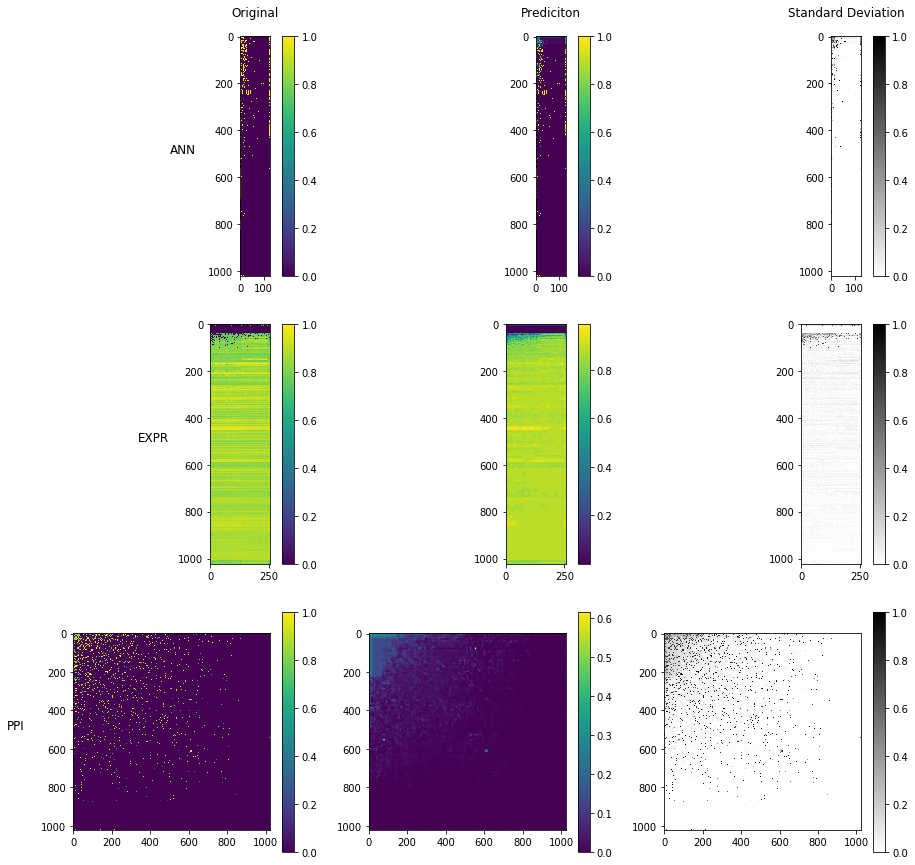

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_05/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;
    
    
cols = ['{}'.format(col) for col in ['Original', 'Prediciton', 'Standard Deviation']]
rows = ['{}'.format(row) for row in ['ANN', 'EXPR', 'PPI']]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    
for i in range(len(model.org_data)):
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[i][0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))
    ax.set_ylabel(rows[i], labelpad=25, rotation=0, size='large')
    if i == 0:
        ax.set_title(cols[0], pad=20)

    ax = axes[i][1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))
    if i == 0:
        ax.set_title(cols[1], pad=20)

    ax = axes[i][2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    if i == 0:
        ax.set_title(cols[2], pad=20)
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[i][0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[i][1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[i][2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict_all.png')

plt.show()


6407
131072

[19.02236938  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.97763062]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
<a list of 20 Patch objects>
250086
262144

[0.91995239 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.1210022  1.25259399 5.46211243 8.74320984
 3.17581177 0.32531738]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
<a list of 20 Patch objects>
31894
1048576

[1.94023323e+01 7.82012939e-03 8.48770142e-03 3.16619873e-03
 4.57763672e-03 2.72750854e-03 4.53948975e-03 5.03540039e-03
 6.80923462e-03 1.14250183e-02 1.20162964e-02 1.42478943e-02
 1.38664246e-02 2.04277039e-02 2.67601013e-02 4.40216064e-02
 2.975463

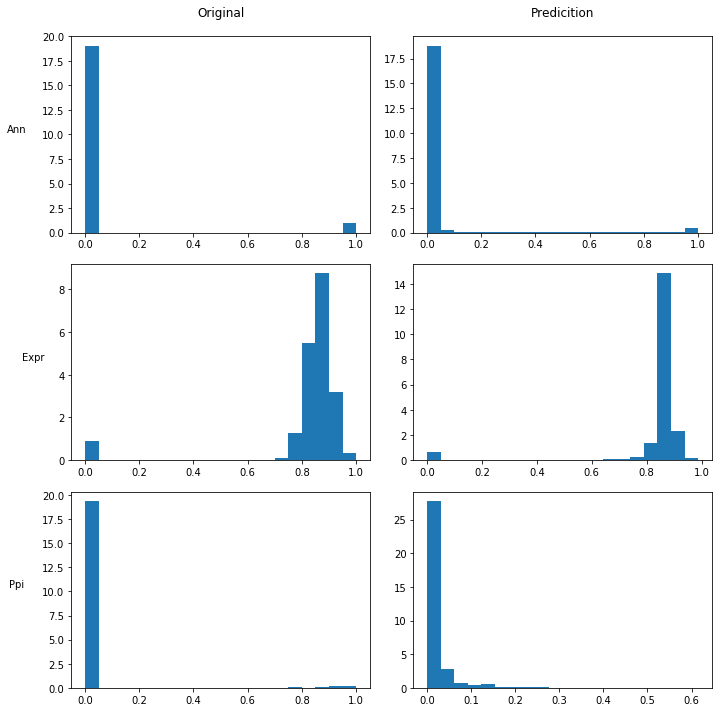

In [66]:
# num_bins = 20
cols = ['Original', 'Predicition']
rows = ['Ann', 'Expr', 'Ppi']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, org_data in enumerate(model.org_data):
    org_data = org_data.flatten()
    pred_data = model.predict_data[i].flatten()
    
    ax = axes[i][0]
#     bins=df['Generosity'].quantile(org_data)
# the histogram of the data
    n, bins, patches = ax.hist(org_data, num_bins, density=1)
    print(len(np.nonzero(org_data)[0]))
    print(len(org_data))
    print()
    
    print(n)
    print(bins)
    print(patches)

    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=1)
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


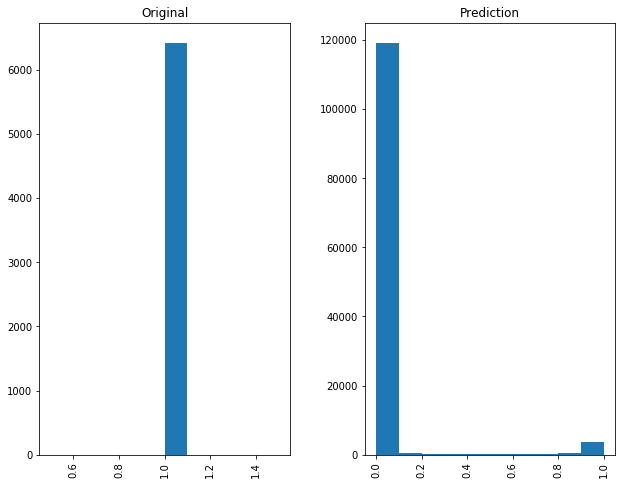

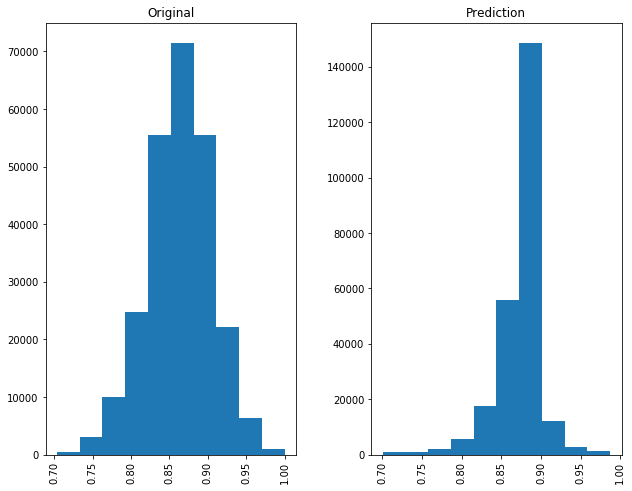

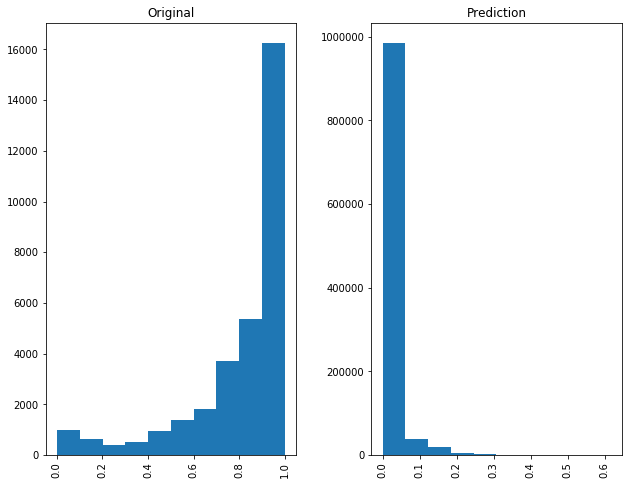

In [54]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

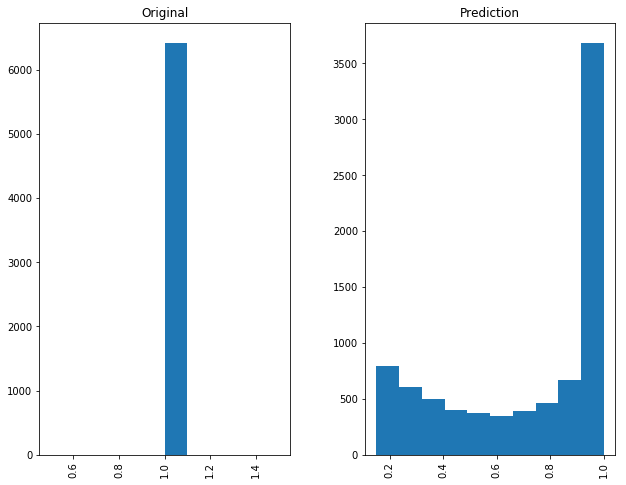

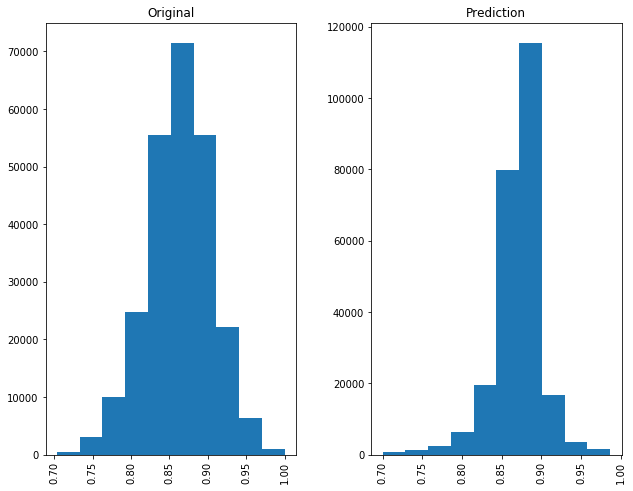

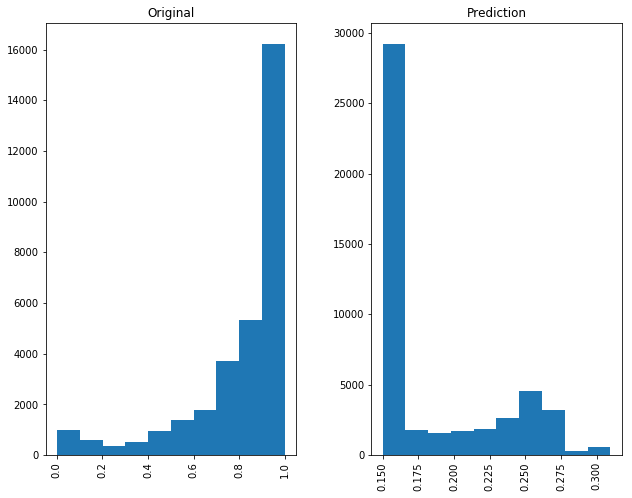

In [9]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.15]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.15]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


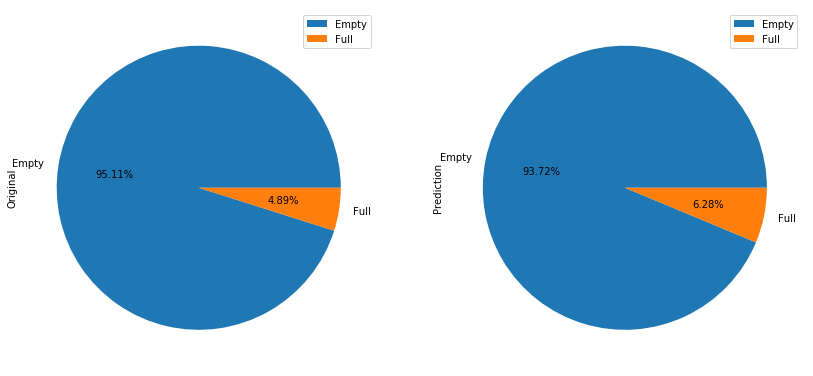

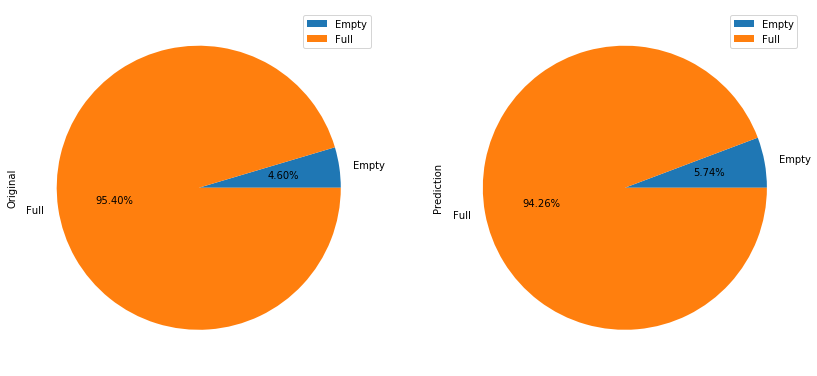

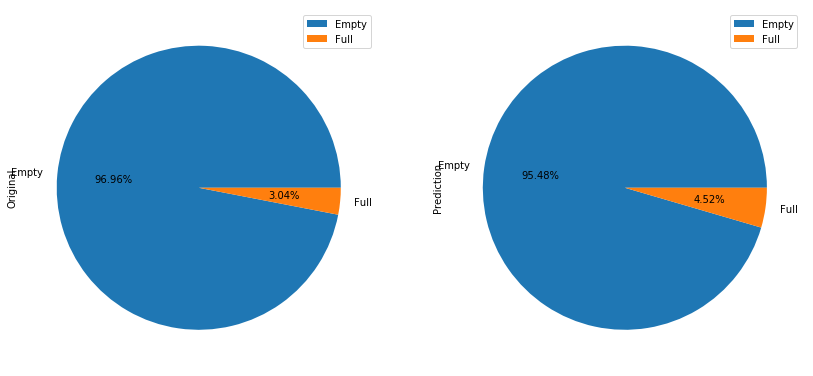

In [10]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.15]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.15]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

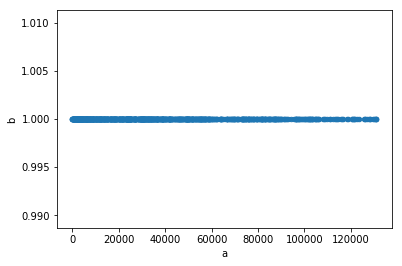

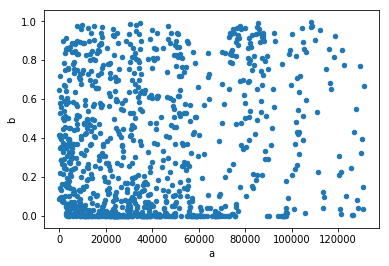

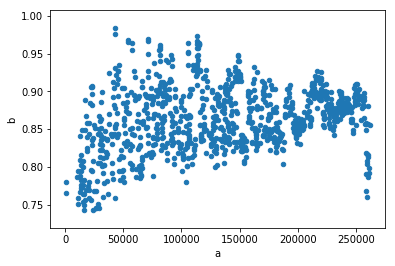

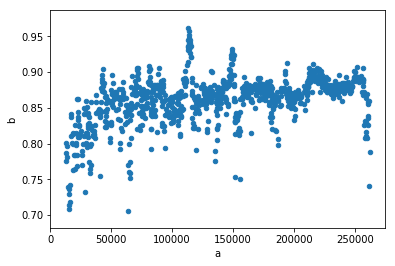

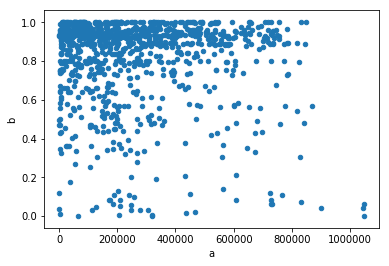

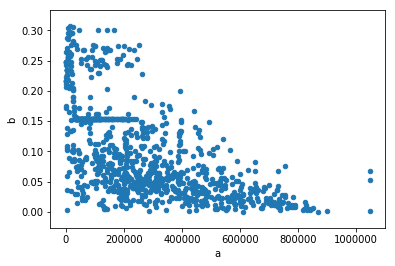

In [9]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

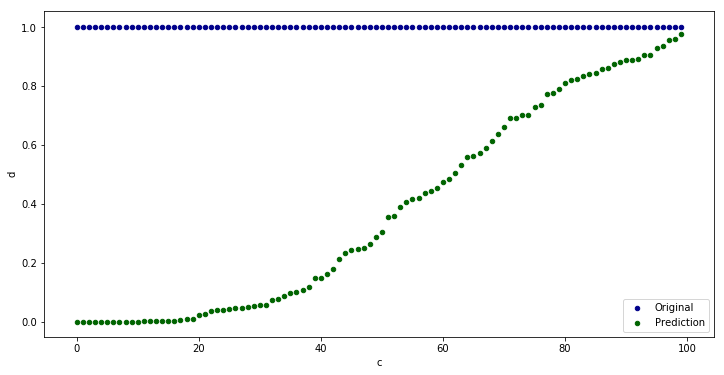

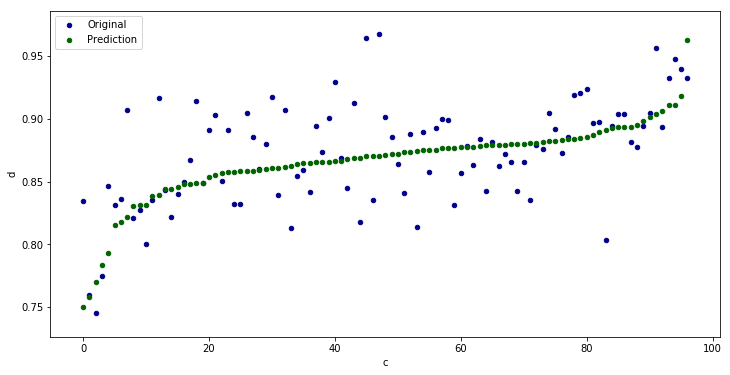

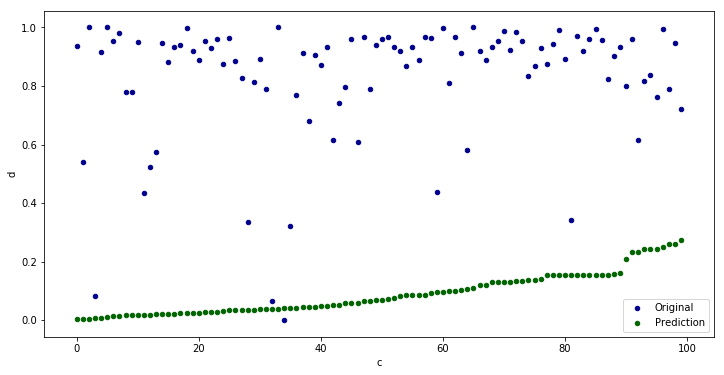

In [16]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[400:500])):
        if i == 0:
            if predict_data[j][1] > 0:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

            
    data = sorted(data, key=lambda l:l[3])
    for j in range(len(data)):
        data[j][0] = j
        data[j][2] = j
    
    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

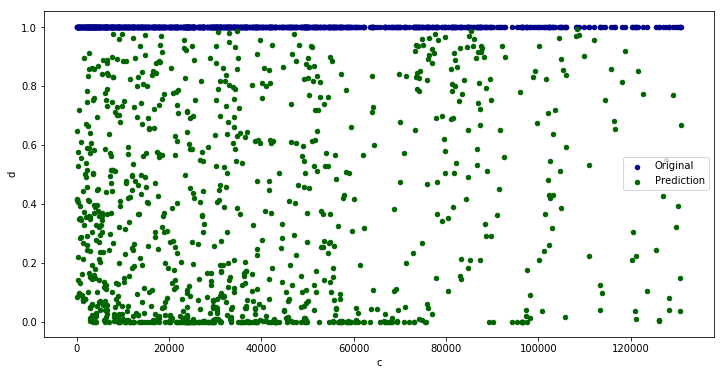

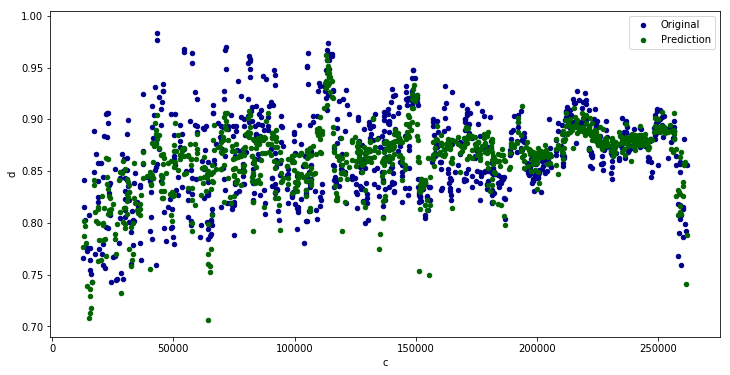

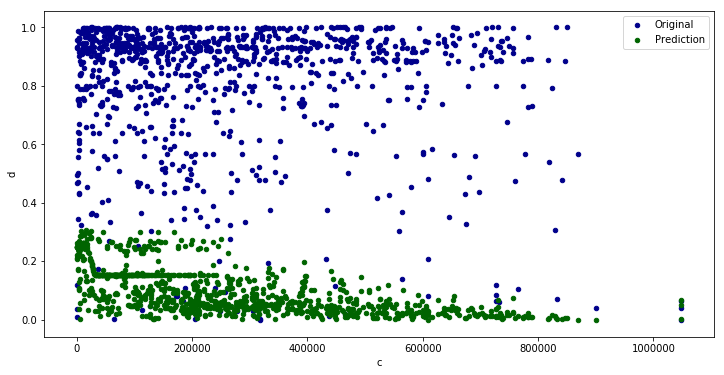

In [11]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    
            
    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

In [19]:
from builtins import enumerate

print(__doc__)

# from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import KFold
import numpy as np

from skfusion import datasets
from skfusion import fusion as skf

import sys
#sys.path.append('/mag/scripts')
sys.path.append('/home/lpodgorsek/mag/scripts')
import utilityFunctions as uf
import base2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl


%load_ext autoreload
%autoreload 2

dicty = datasets.load_dicty()
gene = dicty.get_object_type("Gene")
go_term = dicty.get_object_type("GO term")
exp_cond = dicty.get_object_type("Experimental condition")

dicty[gene][go_term][0].data = base2.resize_rows_and_columns_data(dicty[gene][go_term][0].data, 2)
dicty[gene][exp_cond][0].data = base2.resize_rows_and_columns_data(dicty[gene][exp_cond][0].data, 2)
dicty[gene][gene][0].data = base2.resize_rows_and_columns_data(dicty[gene][gene][0].data, 2)

dicty[gene][go_term][0].data = uf.normalization(dicty[gene][go_term][0].data)
dicty[gene][exp_cond][0].data = uf.normalization(dicty[gene][exp_cond][0].data)
dicty[gene][gene][0].data = uf.normalization(dicty[gene][gene][0].data)

dicty[gene][go_term][0].data = uf.order_by_clustering(dicty[gene][go_term][0].data, 'single')
dicty[gene][exp_cond][0].data = uf.order_by_clustering(dicty[gene][exp_cond][0].data, 'single')
dicty[gene][gene][0].data = uf.order_by_clustering(dicty[gene][gene][0].data, 'single')

n_folds = 10
n_genes = dicty[gene][go_term][0].data.shape[0]

kfold = KFold(n_splits=n_folds)
fold_mse = np.zeros(n_folds)
ann_mask = np.zeros_like(dicty[gene][go_term][0].data).astype('bool')

relations = [
    skf.Relation(dicty[gene][go_term][0].data, gene, go_term),
    skf.Relation(dicty[gene][exp_cond][0].data, gene, exp_cond),
    skf.Relation(dicty[gene][gene][0].data, gene, gene)]
fusion_graph = skf.FusionGraph(relations)
fuser = skf.Dfmc(max_iter=30, n_run=1, init_type='random', random_state=0)


org_data_DFMF = dicty[gene][go_term][0].data
predict_DFMF = np.empty((0, 128))

data_idx = [x for x in range(n_genes)]
for i, (train_idx, test_idx) in enumerate(kfold.split(data_idx)):
    ann_mask[:] = False
    ann_mask[test_idx, :] = True
    fusion_graph[gene][go_term][0].mask = ann_mask
    

    fuser.fuse(fusion_graph)
    pred_ann = fuser.complete(fuser.fusion_graph[gene][go_term][0])[test_idx]
    true_ann = dicty[gene][go_term][0].data[test_idx]
    fold_mse[i] = metrics.mean_squared_error(pred_ann, true_ann)
    predict_DFMF = np.r_[predict_DFMF, pred_ann]

print("MSE: %5.4f" % np.mean(fold_mse))

def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data

test_cells = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ann.npz')
predict_cells = []
org_cells = []
# test_cells = test_cells[:10]

avg_diff = 0
predict_data = predict_DFMF.flatten()
# print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
# print("---------------------------------------------------------------------------------------")
for i in range(len(test_cells)):
    org_val = test_cells[i][1]
    predict_val = predict_data[test_cells[i][0]]
    diff_abs = np.abs(org_val - predict_val)
#     print(str(test_cells[i]) + ' ' + format(predict_val, '.5f') + ' ' + format(org_val, '.5f') + ' ' + format(diff_abs, '.5f') )
    
    avg_diff += diff_abs
    org_cells.append([test_cells[i][0], test_cells[i][1]])
    predict_cells.append([test_cells[i][0], predict_val])
    

# print()
# print("---------------------------------------------------------------------------------------")

val = avg_diff*100/len(test_cells)
# print("\t\t" + format(val, '.5f') + "%", end="\t")
# print()

Automatically created module for IPython interactive environment
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MSE: 0.0329


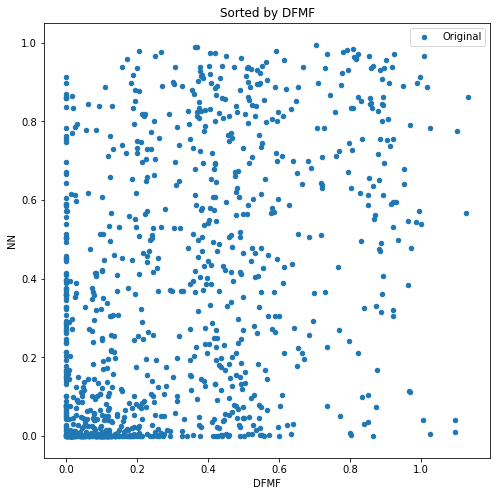

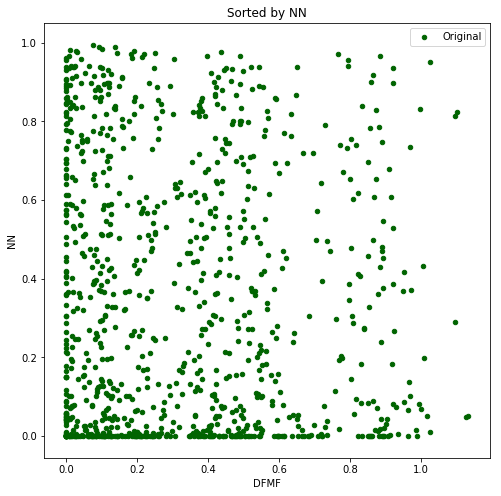

In [62]:
org_data = model.saved_cells_for_test[0]
predict_data = model.predict_saved_cells_for_test[0]
data = []

# podatki urejenei po index
predict_data = sorted(predict_data, key=lambda l:l[0])
predict_cells = sorted(predict_cells, key=lambda l:l[0])

for j in range(len(org_data)):
    data.append([predict_cells[j][1], predict_data[j][1]])

data = sorted(data, key=lambda l:l[0])
# for j in range(len(data)):
#     data[j][1] = j
    
df = pd.DataFrame(data, columns=['DFMF', 'NN'])

fig, ax = plt.subplots(figsize=(8,8))
ax = df.plot.scatter(x='DFMF', y='NN', label='Original', ax=ax);
ax.title.set_text('Sorted by DFMF')
# ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax);
# ax = df.plot.scatter(x='e', y='f', color='Yellow', label='DFMF', ax=ax);
# fig.savefig(path + 'scatter_org_vs_prediction_vs_DFMF' + str(i) + '.png')

org_data = model.saved_cells_for_test[0]
predict_data = model.predict_saved_cells_for_test[0]
data = []
for j in range(len(org_data)):
    data.append([predict_cells[j][1], predict_data[j][1]])

data = sorted(data, key=lambda l:l[1])
# for j in range(len(data)):
#     data[j][0] = j
    
df = pd.DataFrame(data, columns=['DFMF', 'NN'])

fig, ax = plt.subplots(figsize=(8,8))
ax = df.plot.scatter(x='DFMF', y='NN', color='DarkGreen', label='Original', ax=ax);
ax.title.set_text('Sorted by NN')
# ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax);
# ax = df.plot.scatter(x='e', y='f', color='Yellow', label='DFMF', ax=ax);
# fig.savefig(path + 'scatter_org_vs_prediction_vs_DFMF' + str(i) + '.png')